In [194]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import pymysql
from sqlalchemy import create_engine
import os

try:
    os.chdir(path)
except:
    path = os.getcwd()
    os.chdir(path)
    pass
os.environ['TZ'] = 'Asia/Calcutta'
import time
try:
    time.tzset()
except:
    pass

from bypl_support import *

from pylab import rcParams
rcParams['figure.figsize'] = 18,6

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from DBHelper import DbHelper
db = DbHelper()
import seaborn as sns

In [2]:
raw_df  = preprocess().fetch_data('bypl_data','train','holidays.csv')
raw_wdf = preprocess().weather('brpl_weather_data',8,{13:[1]},'no')

Importing pickle file for UDM load data...
pickle file imported
Fetching recent data to check for updates...
Updating data...
Processing and pickling updated data...
Finished processing updated load data
Removing holidays...
Load data prepared
Fetching weather pickle file
Fetching weather data from api
location 13 data added
last date for actual weather data for plant id 13 is 2020-04-21
Processing load-weighted weather averages...
Pickling updated weather actuals...
Adding derivatives...
Final derivatives added
Weather data transformation complete


In [50]:
dates = date(2020,4,17)

df,wdf = raw_df.copy(), raw_wdf.copy()

df = df[df.date <= dates]

In [45]:
# Not taking last 4 days data because it contains rain data also

Text(0.5, 1.0, '2020 (Apr)')

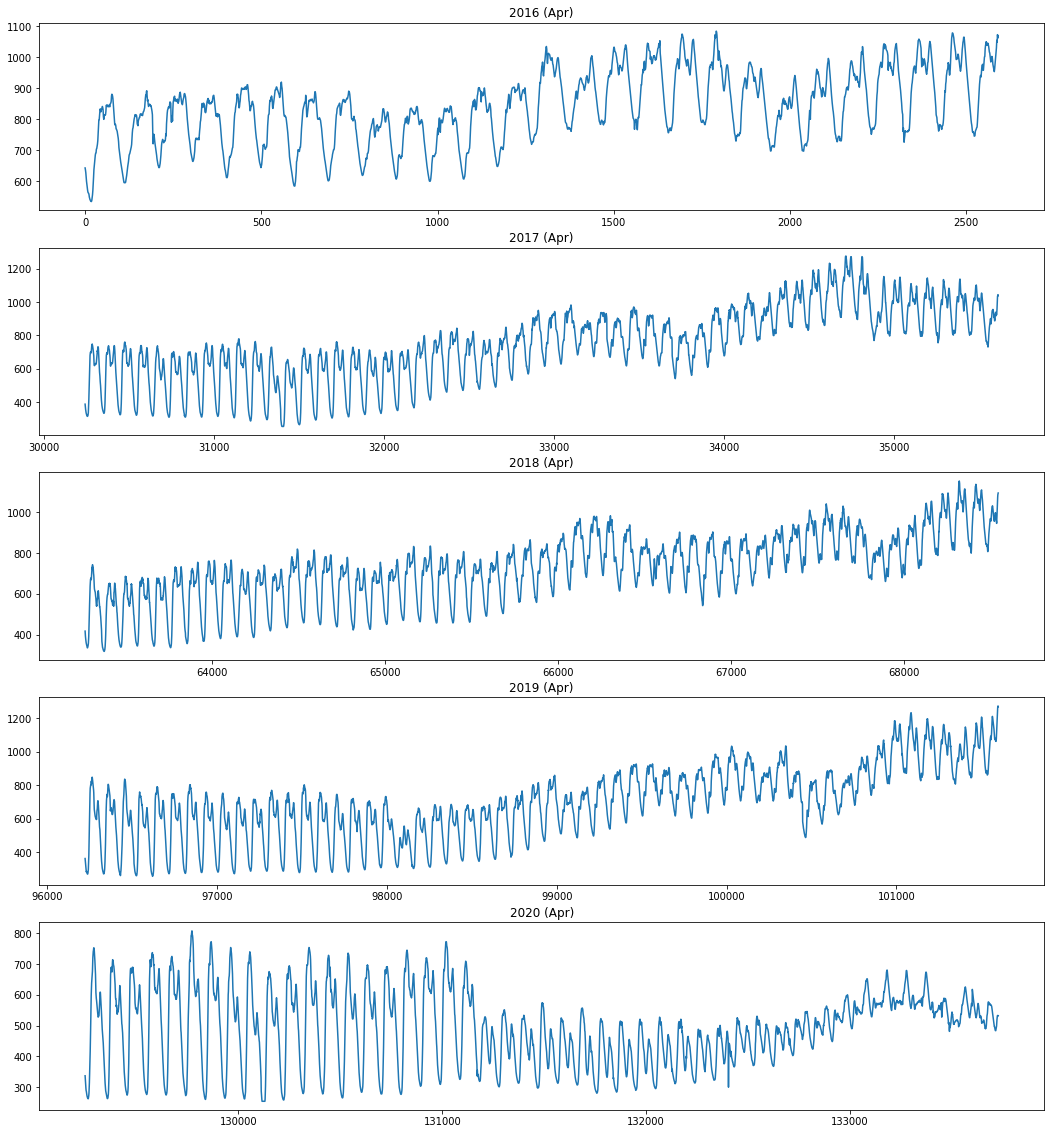

In [10]:
zx = df_copy[(df_copy.datetime.dt.month == 4) | (df_copy.datetime.dt.month == 3)]
#zx = df_copy[(df_copy.datetime.dt.month == 4)]


fig, ax = plt.subplots(5,1)
ax[0].plot(zx.load[zx.datetime.dt.year == 2016])
ax[0].set_title("2016 (Apr)")
ax[1].plot(zx.load[zx.datetime.dt.year == 2017])
ax[1].set_title("2017 (Apr)")
ax[2].plot(zx.load[zx.datetime.dt.year == 2018])
ax[2].set_title("2018 (Apr)")
ax[3].plot(zx.load[zx.datetime.dt.year == 2019])
ax[3].set_title("2019 (Apr)")
ax[4].plot(zx.load[zx.datetime.dt.year == 2020])
ax[4].set_title("2020 (Apr)")

#plt.savefig("load.png")

## Feature engineering

In [4]:
def data_selection(data, year, month):
    temp = data[data.year.isin(year)]
    temp = temp[temp.month.isin(month)]
    return temp.reset_index(drop = True)

In [271]:
#Merge load and weather dataframes and add features and cross-features
def feature_eng(df,wdf):
    try:
        df = df.drop_duplicates('datetime', keep='first')
        df['date']   = df.datetime.dt.date
        df['tb']     = df.datetime.apply(lambda x : ((x.hour*60 + x.minute)//15+1))
        df['dow']    = df.datetime.dt.dayofweek
        df['weekend']= np.where(df['dow'] > 5, 1, 0)
        df['hour']   = df.datetime.dt.hour + 1
        df['doy']    = df.datetime.dt.dayofyear
        df['month']  = df.datetime.dt.month
        df['year']   = df.datetime.dt.year
        df['woy']    = df.datetime.dt.weekofyear
        
        #Adding lags
        print('Adding lags...')
        df['lag2b'] = df.load.shift(2)
        df['lag1h'] = df.load.shift(4)
        df['lag4h'] = df.load.shift(16)
        df['lag1d']  = df.load.shift(96)
        df['lag2d']  = df.load.shift(192)
        df['lag3d']  = df.load.shift(288)
        df['lag4d']  = df.load.shift(96*4)

        
        #Adding ewms for load
        print('Adding ewms for load...')
        df['load_wm2h'] = df['load'].ewm(span=8).mean()
        df['load_wm3h'] = df['load'].ewm(span=12).mean()
        df['load_wm5h'] = df['load'].ewm(span=20).mean()
        df['load_wm24h'] = df['load'].ewm(span=96).mean()

        
        #Adding sine derivatives to time variables
        print('Adding sine derivatives to time variables...')
        df['sin_doy']    = misc().sinwave(df, 'doy', 365)
        df['sin_tb']     = misc().sinwave(df, 'tb',   96)
        df['sin_dow']    = misc().sinwave(df, 'dow',   7)
        df['sin_month']  = misc().sinwave(df, 'month',12)
        df['sin_woy']    = misc().sinwave(df, "woy",  52)
        
        #Adding the hourly running mean for load
        print('Adding the hourly running mean for load...')
        hour_mean = df.groupby(['date','hour'])['load'].mean().reset_index()
        hour_mean = hour_mean.rename(columns = {'load':'hour_mean'})
        df = pd.merge(df, hour_mean, on=['date','hour'], how='left')
        
    except Exception as e:
        print("Error in adding time based features for load : {a}".format(a=e))    

    print('Merging load and weather databases...')    
    try:
        df = pd.merge(df, wdf, on='datetime', how='inner')
    except Exception as e:
        print("Error in merging load and weather databases : {a}".format(a=e))    

    print('Adding final features...')
    try:
        df['tb_aptemp'] = df.tb * df.apparent_temperature
        df['load_aptemp'] = df.load * df.apparent_temperature
        df['aptemp_mean_6h'] = df['apparent_temperature'].ewm(span=24).mean()
        df['aptemp_mean_12h'] = df['apparent_temperature'].ewm(span=48).mean()
        df['temperature_ewm'] = df['temperature'].ewm(span=48).mean()
        df['dp_ewm'] = df['dew_point'].ewm(span=48).mean()
        df['hm12'] = df['humidity'].ewm(span=48).mean()
        df['wsp_12'] = df['wind_speed'].ewm(span=48).mean()
        df['cc_12'] = df['cloud_cover'].ewm(span=48).mean()
        df['tb_load'] = df.tb * df.load
        df['sdtbrm']  = (df.load + df.load.shift(480))/2
        df['sdtbrm2'] = (df.load + df.load.shift(576))/2
        df['3tbrm']   = (df.load + df.lag1d + df.lag2d)/3
        df['3tbrmw']  = df['3tbrm'].ewm(span=48).mean()
        df['lag1dwm'] = df['lag1d'].ewm(span=48).mean()
        df['lag2dwm'] = df['lag2d'].ewm(span=48).mean()
        df['lag3dwm'] = df['lag3d'].ewm(span=48).mean()
        df['lag4dwm'] = df['lag4d'].ewm(span=48).mean()
        df['load_aptemp_ewm6'] = df['load_aptemp'].ewm(span=24).mean()
        df['load_aptemp_ewm12'] = df['load_aptemp'].ewm(span=48).mean()
        df['load_aptemp_ewm24'] = df['load_aptemp'].ewm(span=96).mean()
        df['lagcwm'] = (df.lag1dwm + df.lag2dwm + df.lag3dwm) / 3
        df['lag4avg'] = (df.lag1d + df.lag2d + df.lag3d)/4
        df['lag_df'] = ((df['lag1d']  - df['lag2d'])  + (df['lag2d'] - df['lag3d']))/2
        df['load_wm12h'] = df['load'].ewm(span=48).mean()
        df['wt']=df.dow*df.hour
        df['tm']=df.temperature*df.month
        df['tm2']=(df.temperature**2)
        df['tm3']=(df.aptemp_mean_12h**2)
        df['tm4']=df.aptemp_mean_12h*df.month
        df['th']=df.temperature*df.hour
        df['th2']=(df.temperature**2)*df.hour
        df['th3']=(df.temperature**3)*df.hour
        df['tb_load']=df.load*df.tb
        
        # APTEMP LAGS
        df['aptemp_lag12h'] = df.apparent_temperature.shift(48)
        df['aptemp_lag1d']  = df.apparent_temperature.shift(96)
        df['humidex_lag1d'] = df.humidex.shift(96)

        print('Feature engineering completed successfully')
    except Exception as e:
        print("Error in adding final features : {a}".format(a=e))    
    return df

In [272]:
final_df = feature_eng(df, wdf)

Adding lags...
Adding ewms for load...
Adding sine derivatives to time variables...
Adding the hourly running mean for load...
Merging load and weather databases...
Adding final features...
Feature engineering completed successfully


In [170]:
years = [2020, 2019, 2018]
months = [4]
new_final_df = data_selection(final_df, years, months)

In [124]:
new_final_df.loc[new_final_df.year < 2020, 'load']  = new_final_df.loc[new_final_df.year < 2020, 'load']  - 250

In [ ]:
#Specify which features do you want to use in the model
features = ['datetime','load','lag1','lag2','lag3','lag5',
            'lag4wm', # lag 4th days exponential weight
            'hour_mean','sin_doy','dow','tb_aptemp',
            'sdtbrm',         # today + 5th day lag average 
            '3tbrm','3tbrmw', # last 3 days load average
            'sdtbrm2',        # today + 6th day lag average
            'temperature_ewm','apparent_temperature',
            'RH','dew_point',
            'aptemp_mean_12h','aptemp_mean_6h','doy','humidex',
            'tm','tm2','tm3', 'tm4',   # apparent_temp 12 hour expoentail * month
            'load_wm3h','month','year','hour',
            'humidity','sin_tb',
            'hm12','dp_ewm',
            'lagcwm', # last days expoential then average
            'load_wm12h','wci','wsp_12','cc_12',
            'wind_speed','cloud_cover','temperature',
            'wt', # dow * hour
            'load_aptemp','load_aptemp_ewm6','load_aptemp_ewm12',
            'tb_load']


#Specify weather and time based variables to 'shift' them up when running the model as is required
shift_features = ['temperature_ewm','dp_ewm','temperature','apparent_temperature','dew_point','RH','aptemp_mean_6h',\
                'aptemp_mean_12h','humidex','dow','tb_aptemp','humidity','doy','month','hm12','wind_speed',\
                'cloud_cover','wsp_12','cc_12','wci','wt','tm','tm2','tm3','tm4']

#specify the features you want the model to treat as categorical. Note: This only works with lightgbm
categorical_features = ['dow','month','year','hour']


In [246]:
load_features = ['datetime','date','load','tb','dow','weekend','hour','doy','month','year','woy',
                 'lag2b','lag1h','lag4h','lag1d', 'lag2d', 'lag3d', 'sdtbrm', 'sdtbrm2', '3tbrm', '3tbrmw',
                 'lag1dwm', 'lag2dwm', 'lag3dwm', 'lagcwm', 'lag4avg', 'lag_df',
                 'load_wm2h', 'load_wm3h', 'load_wm5h','load_wm12h', 'load_wm24h',
                 'sin_doy', 'sin_tb', 'sin_dow', 'sin_month', 'sin_woy','hour_mean'] 
                
    
weather_feature = [ 'load', 'apparent_temperature', 'temperature', 'humidity', 'dew_point','wind_speed', 'cloud_cover', 
                    'humidex', 'RH', 'wci', 'tb_aptemp','load_aptemp', 'aptemp_mean_6h', 'aptemp_mean_12h', 
                    'load_aptemp_ewm6', 'load_aptemp_ewm12', 'load_aptemp_ewm24',
                    'temperature_ewm','dp_ewm', 'hm12', 'wsp_12', 'cc_12', 'tb_load',
                   'wt', 'tm', 'tm2', 'tm3', 'tm4', 'th', 'th2', 'th3',
                  "aptemp_lag12h", "aptemp_lag1d","humidex_lag1d"]

In [247]:
len(load_features) + len(weather_feature)

72

In [248]:
remove_features = ['dow', 'weekend', 'hour', 'month', 'year', 'sdtbrm2','sin_dow', 'sin_month','sin_doy','sin_woy',
                  "lag4avg", "lag2b","lag1h","lag2h", "load_wm5h","lag_df","load_wm2h", "sin_tb","lag3d","lag3dwm",
                  "lag2dwm", "3tbrmw","woy","doy"]

remove_w_features = ['temperature','humidity','wci','tm2','tm4','th2', 'cloud_cover','dew_point','dp_ewm',"RH",
                    "cc_12","temperature_ewm","th3", 'th', "load_aptemp_ewm12","load_aptemp_ewm24","hm12",
                     "wind_speed","wsp_12","wt", "tm","tm3"]

In [249]:
len(remove_features) + len(remove_w_features)

44

In [257]:
selected_features = []
selected_features.extend(set(load_features) - set(remove_features))
selected_features.extend(set(set(weather_feature) - set(remove_w_features)))
selected_features = list(set(selected_features))

In [258]:
selected_features

['load_wm12h',
 'load_aptemp',
 'lag1d',
 'tb_aptemp',
 'aptemp_mean_6h',
 'doy',
 'date',
 'sdtbrm',
 '3tbrm',
 'tb',
 'woy',
 'load_wm3h',
 'aptemp_lag1d',
 'apparent_temperature',
 'hour_mean',
 'humidex',
 'humidex_lag1d',
 'lag4h',
 'load_wm24h',
 'datetime',
 'lag2d',
 'lagcwm',
 'lag1dwm',
 'aptemp_lag12h',
 'aptemp_mean_12h',
 'load_aptemp_ewm6',
 'tb_load',
 'load']

In [261]:
final_df[selected_features]

load_wm12h   load_aptemp   lag1d  tb_aptemp  aptemp_mean_6h  doy  \
0       642.840000  17581.674000     NaN      27.35       27.350000   93   
1       639.522292  17648.889900     NaN      55.47       27.550521   93   
2       635.353696  17645.862400     NaN      84.36       27.756377   93   
3       629.512266  17484.396900     NaN     114.02       27.967549   93   
4       623.049324  17326.199700     NaN     144.45       28.184011   93   
...            ...           ...     ...        ...             ...  ...   
133371  600.195053  17531.492675  669.47    2414.77       29.609954  108   
133372  603.058520  17469.321000  677.49    2423.58       29.325958  108   
133373  605.936948  19028.635000  678.75    2655.50       29.239881  108   
133374  608.655440  18831.120000  678.45    2660.00       29.140691  108   
133375  611.156442  18590.557500  675.26    2664.00       29.029436  108   

              date   sdtbrm       3tbrm  tb  woy   load_wm3h  aptemp_lag1d  \
0       2016-04-02      NaN         NaN   1   13  642.840000           NaN   
1       2016-04-02      NaN         NaN   2   13  639.319167           NaN   
2       2016-04-02      NaN         NaN   3   13  634.713949           NaN   
3       2016-04-02      NaN         NaN   4   13  627.979655           NaN   
4       2016-04-02      NaN         NaN   5   13  620.304325           NaN   
...            ...      ...         ...  ..  ...         ...           ...   
133371  2020-04-17  610.335  669.996667  92   16  633.318125       30.9525   
133372  2020-04-17  608.730  674.700000  93   16  639.015336       30.6900   
133373  2020-04-17  608.375  677.263333  94   16  644.332977       30.2500   
133374  2020-04-17  603.530  677.046667  95   16  648.672519       30.0000   
133375  2020-04-17  597.855  673.960000  96   16  651.942901       30.0000   

        apparent_temperature  hour_mean    humidex  humidex_lag1d   lag4h  \
0                    27.3500    630.020  31.335686            NaN     NaN   
1                    27.7350    630.020  31.089340            NaN     NaN   
2                    28.1200    630.020  30.892916            NaN     NaN   
3                    28.5050    630.020  30.743461            NaN     NaN   
4                    28.8900    585.815  30.638169            NaN     NaN   
...                      ...        ...        ...            ...     ...   
133371               26.2475    657.235  31.032683      27.061900  563.15   
133372               26.0600    671.600  30.980948      26.834654  579.53   
133373               28.2500    671.600  31.222338      30.561273  587.74   
133374               28.0000    671.600  30.972338      30.412662  592.80   
133375               27.7500    671.600  30.972338      30.412662  594.88   

        load_wm24h            datetime   lag2d      lagcwm     lag1dwm  \
0       642.840000 2016-04-02 00:00:00     NaN         NaN         NaN   
1       639.556146 2016-04-02 00:15:00     NaN         NaN         NaN   
2       635.460226 2016-04-02 00:30:00     NaN         NaN         NaN   
3       629.766482 2016-04-02 00:45:00     NaN         NaN         NaN   
4       623.506302 2016-04-02 01:00:00     NaN         NaN         NaN   
...            ...                 ...     ...         ...         ...   
133371  593.926340 2020-04-17 22:45:00  672.59  597.680533  602.501882   
133372  595.502085 2020-04-17 23:00:00  676.26  600.574389  605.562622   
133373  597.111939 2020-04-17 23:15:00  679.46  603.399788  608.549862   
133374  598.667157 2020-04-17 23:30:00  680.15  606.051361  611.402928   
133375  600.136494 2020-04-17 23:45:00  676.69  608.416748  614.009340   

        aptemp_lag12h  aptemp_mean_12h  load_aptemp_ewm6   tb_load    load  
0                 NaN        27.350000      17581.674000    642.84  642.84  
1                 NaN        27.546510      17616.682281   1272.68  636.34  
2                 NaN        27.745693      17627.230329   1882.56  627.52  
3                 NaN        27.9475

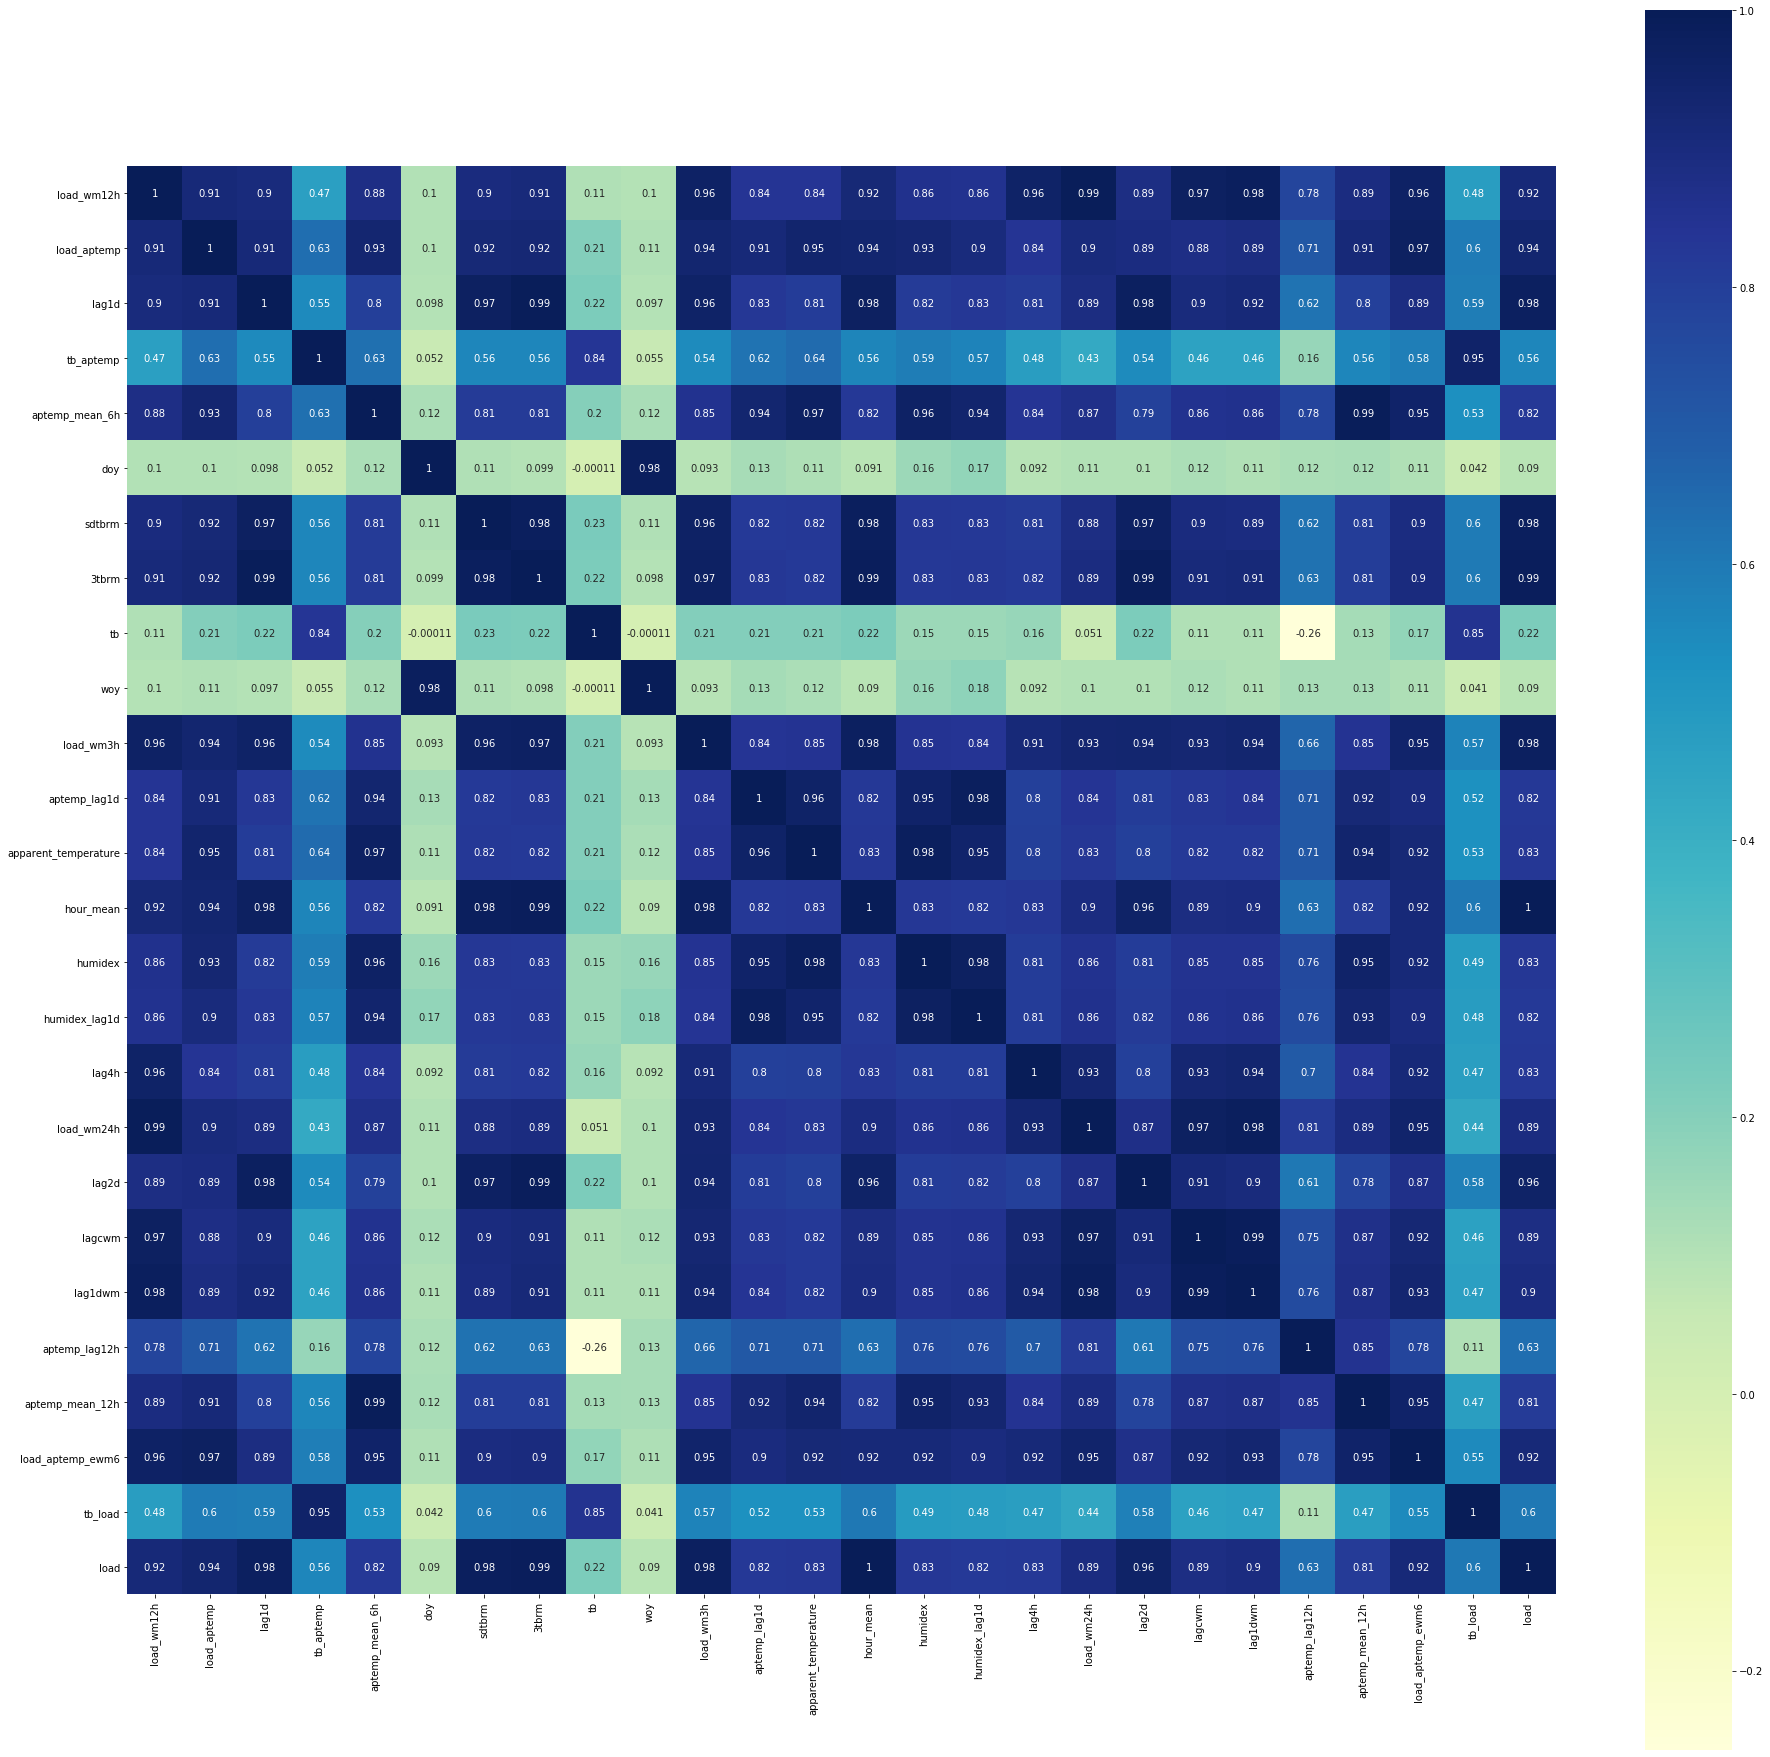

In [260]:
plt.figure(figsize=(32,32))
sns.heatmap(final_df[selected_features].corr(),
            square=True,annot=True,
            cmap="YlGnBu"
           )
plt.savefig("newfig.png")
plt.show()

# Modelling part:

In [335]:
selected_shift_features = ['aptemp_mean_6h','tb_aptemp','aptemp_lag1d','aptemp_lag12h','aptemp_mean_12h']

In [332]:
final_df[selected_features].isna().sum()

load_wm12h                0
load_aptemp               0
lag1d                    96
tb_aptemp                 0
aptemp_mean_6h            0
doy                       0
date                      0
sdtbrm                  480
3tbrm                   192
tb                        0
woy                       0
load_wm3h                 0
aptemp_lag1d             96
apparent_temperature      0
hour_mean                 0
humidex                   0
humidex_lag1d            96
lag4h                    16
load_wm24h                0
datetime                  0
lag2d                   192
lagcwm                  288
lag1dwm                  96
aptemp_lag12h            48
aptemp_mean_12h           0
load_aptemp_ewm6          0
tb_load                   0
load                      0
dtype: int64

In [267]:
final_df[selected_features].shape

(133376, 28)

In [268]:
# First we will train by all features which is using currently

In [269]:
final_df.columns

Index(['datetime', 'date', 'load', 'tb', 'dow', 'weekend', 'hour', 'doy',
       'month', 'year', 'woy', 'lag2b', 'lag1h', 'lag4h', 'lag1d', 'lag2d',
       'lag3d', 'load_wm2h', 'load_wm3h', 'load_wm5h', 'load_wm24h', 'sin_doy',
       'sin_tb', 'sin_dow', 'sin_month', 'sin_woy', 'hour_mean',
       'apparent_temperature', 'temperature', 'humidity', 'dew_point',
       'wind_speed', 'cloud_cover', 'humidex', 'RH', 'wci', 'tb_aptemp',
       'load_aptemp', 'aptemp_mean_6h', 'aptemp_mean_12h', 'temperature_ewm',
       'dp_ewm', 'hm12', 'wsp_12', 'cc_12', 'tb_load', 'sdtbrm', 'sdtbrm2',
       '3tbrm', '3tbrmw', 'lag1dwm', 'lag2dwm', 'lag3dwm', 'load_aptemp_ewm6',
       'load_aptemp_ewm12', 'load_aptemp_ewm24', 'lagcwm', 'lag4avg', 'lag_df',
       'load_wm12h', 'wt', 'tm', 'tm2', 'tm3', 'tm4', 'th', 'th2', 'th3',
       'aptemp_lag12h', 'aptemp_lag1d', 'humidex_lag1d'],
      dtype='object')

In [281]:
#Specify which features do you want to use in the model
features = ['datetime','load','lag1d','lag2d','lag3d',
            'lag4dwm', # lag 4th days exponential weight
            'hour_mean','sin_doy','dow','tb_aptemp',
            'sdtbrm',         # today + 5th day lag average 
            '3tbrm','3tbrmw', # last 3 days load average
            'sdtbrm2',        # today + 6th day lag average
            'temperature_ewm','apparent_temperature',
            'RH','dew_point',
            'aptemp_mean_12h','aptemp_mean_6h','doy','humidex',
            'tm','tm2','tm3', 'tm4',   # apparent_temp 12 hour expoentail * month
            'load_wm3h','month','year','hour',
            'humidity','sin_tb',
            'hm12','dp_ewm',
            'lagcwm', # last days expoential then average
            'load_wm12h','wci','wsp_12','cc_12',
            'wind_speed','cloud_cover','temperature',
            'wt', # dow * hour
            'load_aptemp','load_aptemp_ewm6','load_aptemp_ewm12',
            'tb_load']


#Specify weather and time based variables to 'shift' them up when running the model as is required
shift_features = ['temperature_ewm','dp_ewm','temperature','apparent_temperature','dew_point','RH','aptemp_mean_6h',\
                'aptemp_mean_12h','humidex','dow','tb_aptemp','humidity','doy','month','hm12','wind_speed',\
                'cloud_cover','wsp_12','cc_12','wci','wt','tm','tm2','tm3','tm4']

#specify the features you want the model to treat as categorical. Note: This only works with lightgbm
categorical_features = ['dow','month','year','hour']


In [348]:
i = 192
df4 = final_df[selected_features]
df4['target'] = df4.load.shift(-i) 

for j in selected_shift_features:
    df4[j] = df4[j].shift(-i)

df4.dropna(inplace=True)
x, y = df4.drop('target',1).copy(), df4[['datetime','target']].copy()

In [349]:
validation = 15

In [350]:
x_train, y_train = x[x['datetime'] < misc().get_date(0) + ' 00:00:00'], y[y['datetime'] < misc().get_date(0) + ' 00:00:00']

In [358]:
x_train = x_train.drop(['date','datetime'],axis=1)
y_train = y_train.drop(['datetime'], axis=1)

In [359]:
x_train, y_train = x_train.iloc[:-validation*96,].reset_index(drop=True), y_train.iloc[:-validation*96].reset_index(drop=True)
x_val, y_val = x_train.iloc[-validation*96:,].reset_index(drop=True), y_train.iloc[-validation*96:].reset_index(drop=True)

In [346]:
x_train = x_train.iloc[:,1:]
x_val = x_val.iloc[:,1:]
y_train = y_train.iloc[:,1:]
y_val = y_val.iloc[:,1:]

In [314]:
import xgboost as xgb

In [323]:
#from xgboost import XGB
from xgboost import plot_importance

In [331]:
data_matrix  = xgb.DMatrix(x_train, label=y_train)
data_matrixv = xgb.DMatrix(x_val, label=y_val)
                   
params = {'objective':'reg:squarederror',
          'booster':'gbtree',
          'max_depth':11,
          'learning_rate':0.05,
          'colsample_bytree':0.6,
          'colsample_bylevel':0.6,
          'subsample':0.75,
          'min_child_weight':1,
          'gamma':1}
            
model_xgb = xgb.train(params, data_matrix, num_boost_round = 200,
                      evals=[(data_matrixv, "Test")],early_stopping_rounds=15)


[0]	Test-rmse:458.17929
Will train until Test-rmse hasn't improved in 15 rounds.
[1]	Test-rmse:434.25510
[2]	Test-rmse:411.68948
[3]	Test-rmse:390.25027
[4]	Test-rmse:369.76221
[5]	Test-rmse:350.45044
[6]	Test-rmse:331.98773
[7]	Test-rmse:314.63379
[8]	Test-rmse:297.99268
[9]	Test-rmse:282.65659
[10]	Test-rmse:267.85934
[11]	Test-rmse:253.80467
[12]	Test-rmse:240.78700
[13]	Test-rmse:228.31947
[14]	Test-rmse:216.28210
[15]	Test-rmse:205.08231
[16]	Test-rmse:194.62003
[17]	Test-rmse:184.56915
[18]	Test-rmse:175.18648
[19]	Test-rmse:166.30794
[20]	Test-rmse:157.72279
[21]	Test-rmse:149.63632
[22]	Test-rmse:142.19844
[23]	Test-rmse:134.82439
[24]	Test-rmse:127.81295
[25]	Test-rmse:121.30049
[26]	Test-rmse:115.15985
[27]	Test-rmse:109.35765
[28]	Test-rmse:103.83941
[29]	Test-rmse:98.54251
[30]	Test-rmse:93.78616
[31]	Test-rmse:89.21392
[32]	Test-rmse:84.89774
[33]	Test-rmse:80.76580
[34]	Test-rmse:76.84803
[35]	Test-rmse:73.08113
[36]	Test-rmse:69.49658
[37]	Test-rmse:66.13619
[38]	Test-rm

In [364]:
data_matrix  = xgb.DMatrix(x_train, label=y_train)
data_matrixv = xgb.DMatrix(x_val, label=y_val)
                   
params = {'objective':'reg:squarederror',
          'booster':'gbtree',
          'max_depth':11,
          'learning_rate':0.05,
          'colsample_bytree':0.6,
          'colsample_bylevel':0.6,
          'subsample':0.75,
          'min_child_weight':1,
          'gamma':1}
            
model_xgb = xgb.train(params, data_matrix, num_boost_round = 200,
                      evals=[(data_matrixv, "Test")],early_stopping_rounds=15)


[0]	Test-rmse:458.06317
Will train until Test-rmse hasn't improved in 15 rounds.
[1]	Test-rmse:433.94583
[2]	Test-rmse:411.25986
[3]	Test-rmse:389.81442
[4]	Test-rmse:369.42386
[5]	Test-rmse:349.90396
[6]	Test-rmse:331.56622
[7]	Test-rmse:314.18912
[8]	Test-rmse:297.63733
[9]	Test-rmse:282.03815
[10]	Test-rmse:267.13724
[11]	Test-rmse:253.07527
[12]	Test-rmse:239.79160
[13]	Test-rmse:227.20212
[14]	Test-rmse:215.07501
[15]	Test-rmse:203.85182
[16]	Test-rmse:193.12344
[17]	Test-rmse:183.25081
[18]	Test-rmse:173.71948
[19]	Test-rmse:164.74869
[20]	Test-rmse:156.19820
[21]	Test-rmse:148.18828
[22]	Test-rmse:140.61406
[23]	Test-rmse:133.43710
[24]	Test-rmse:126.64733
[25]	Test-rmse:120.21744
[26]	Test-rmse:114.02030
[27]	Test-rmse:108.26846
[28]	Test-rmse:102.79172
[29]	Test-rmse:97.71906
[30]	Test-rmse:92.86319
[31]	Test-rmse:88.35036
[32]	Test-rmse:83.98391
[33]	Test-rmse:79.85992
[34]	Test-rmse:76.07730
[35]	Test-rmse:72.51646
[36]	Test-rmse:68.96515
[37]	Test-rmse:65.81655
[38]	Test-rm

<Figure size 2592x576 with 0 Axes>

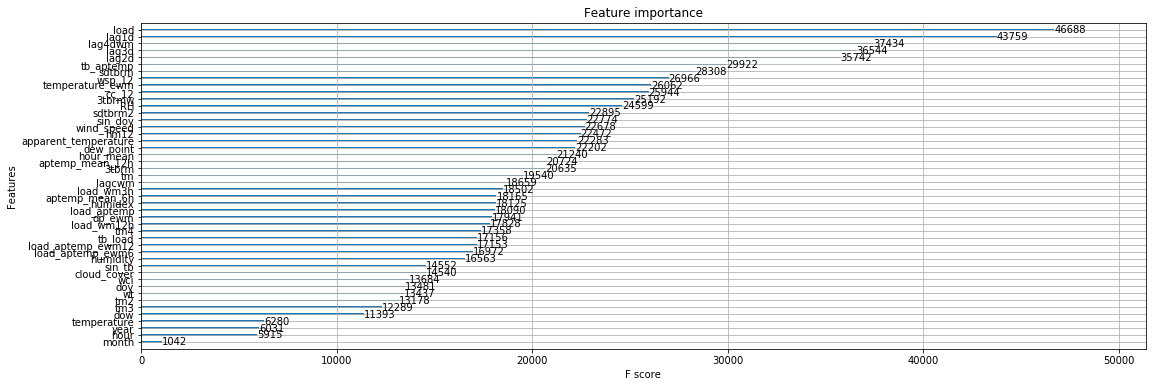

In [325]:
plt.figure(figsize=(36,8))
plot_importance(model_xgb)

In [327]:
inf_df  = preprocess().fetch_data('bypl_data','inference','holidays.csv')
inf_wdf = preprocess().weather('brpl_weather_data',8,{13:[1]},"no")

Importing pickle file for UDM load data...
pickle file imported
Fetching recent data to check for updates...
Load data already updated. Proceeding without any changes to pickled file...
Fetching weather pickle file
Fetching weather data from api
location 13 data added
last date for actual weather data for plant id 13 is 2020-04-20
Processing load-weighted weather averages...
Pickling updated weather actuals...
Adding derivatives...
Final derivatives added
Weather data transformation complete


In [365]:
predict_df = feature_eng(inf_df, inf_wdf)

Adding lags...
Adding ewms for load...
Adding sine derivatives to time variables...
Adding the hourly running mean for load...
Merging load and weather databases...
Adding final features...
Feature engineering completed successfully


In [367]:
predict_df.isna().sum()

datetime                  0
date                      0
load                    161
tb                        0
dow                       0
weekend                   0
hour                      0
doy                       0
month                     0
year                      0
woy                       0
lag2b                   161
lag1h                   161
lag4h                   161
lag1d                   161
lag2d                   192
lag3d                   288
lag4d                   384
load_wm2h                 0
load_wm3h                 0
load_wm5h                 0
load_wm24h                0
sin_doy                   0
sin_tb                    0
sin_dow                   0
sin_month                 0
sin_woy                   0
hour_mean               161
apparent_temperature      0
temperature               0
humidity                  0
dew_point                 0
wind_speed                0
cloud_cover               0
humidex                   0
RH                  

In [369]:
predict_df

datetime        date    load  tb  dow  weekend  hour  doy  \
0    2020-04-01 00:00:00  2020-04-01  342.90   1    2        0     1   92   
1    2020-04-01 00:15:00  2020-04-01  336.15   2    2        0     1   92   
2    2020-04-01 00:30:00  2020-04-01  330.42   3    2        0     1   92   
3    2020-04-01 00:45:00  2020-04-01  326.62   4    2        0     1   92   
4    2020-04-01 01:00:00  2020-04-01  321.56   5    2        0     2   92   
...                  ...         ...     ...  ..  ...      ...   ...  ...   
2108 2020-04-22 23:00:00  2020-04-22     NaN  93    2        0    24  113   
2109 2020-04-22 23:15:00  2020-04-22     NaN  94    2        0    24  113   
2110 2020-04-22 23:30:00  2020-04-22     NaN  95    2        0    24  113   
2111 2020-04-22 23:45:00  2020-04-22     NaN  96    2        0    24  113   
2112 2020-04-23 00:00:00  2020-04-23     NaN   1    3        0     1  114   

      month  year  woy   lag2b  lag1h  lag4h  lag1d   lag2d   lag3d   lag4d  \
0         4  2020   14     NaN    NaN    NaN    NaN     NaN     NaN     NaN   
1         4  2020   14     NaN    NaN    NaN    NaN     NaN     NaN     NaN   
2         4  2020   14  342.90    NaN    NaN    NaN     NaN     NaN     NaN   
3         4  2020   14  336.15    NaN    NaN    NaN     NaN     NaN     NaN   
4         4  2020   14  330.42  342.9    NaN    NaN     NaN     NaN     NaN   
...     ...   ...  ...     ...    ...    ...    ...     ...     ...     ...   
2108      4  2020   17     NaN    NaN    NaN    NaN  567.24  622.32  587.15   
2109      4  2020   17     NaN    NaN    NaN    NaN  565.93  624.48  586.11   
2110      4  2020   17     NaN    NaN    NaN    NaN  563.95  625.39  583.53   
2111      4  2020   17     NaN    NaN    NaN    NaN  562.35  622.30  579.83   
2112      4  2020   17     NaN    NaN    NaN    NaN  558.07  617.47  573.43   

       load_wm2h   load_wm3h   load_wm5h  load_wm24h   sin_doy        sin_tb  \
0     342.900000  342.900000  342.900000  342.900000  0.999917  6.540313e-02   
1     339.103125  339.243750  339.356250  339.489844  0.999917  1.305262e-01   
2     335.458912  335.799838  336.074913  336.403361  0.999917  1.950903e-01   
3     332.361043  332.902122  333.345425  333.880563  0.999917  2.588190e-01   
4     329.005821  329.820508  330.494631  331.312721  0.999917  3.214395e-01   
...          ...         ...         ...         ...       ...           ...   
2108  525.322060  520.703994  517.752876  529.494106  0.930724 -1.950903e-01   
2109  525.322060  520.703994  517.752876  529.494106  0.930724 -1.305262e-01   
2110  525.322060  520.703994  517.752876  529.494106  0.930724 -6.540313e-02   
2111  525.322060  520.703994  517.752876  529.494106  0.930724 -2.449294e-16   
2112  525.322060  520.703994  517.752876  529.494106  0.924291  6.540313e-02   

       sin_dow  sin_month   sin_woy  hour_mean  apparent_temperature  \
0     0.974928   0.866025  0.992709   334.0225               24.2000   
1     0.974928   0.866025  0.992709   334.0225               23.9675   
2     0.974928   0.866025  0.992709   334.0225               23.7350   
3     0.974928   0.866025  0.992709   334.0225               23.5025   
4     0.974928   0.866025  0.992709   316.8625               23.2700   
...        ...        ...       ...        ...                   ...   
2108  0.974928   0.866025  0.885456        NaN               28.5000   
2109  0.974928   0.866025  0.885456        NaN               28.2500   
2110  0.974928   0.866025  0.885456        NaN               28.0000   
2111  0.974928   0.866025  0.885456        NaN               28.0000   
2112  0.433884   0.866025  0.885456        NaN               28.0000   

      temperature  humidity  dew_point  wind_speed  cloud_cover    humidex  \
0         24.2000  0.011190      13.40      3.6900         0.37  27.223338   
1         23.9675  0.011243      13.46      3.5325         0.33  27.024839   
2         23.7350  0.011296      13.52      3.3750         0.29  26.826460   
3   

In [428]:
df4 = predict_df[selected_features] 
            
for j in selected_shift_features:
    df4[j] = df4[j].shift(-i)


In [429]:
df4.dropna(inplace=True)

In [432]:
df4

load_wm12h   load_aptemp   lag1d  tb_aptemp  aptemp_mean_6h  doy  \
1824  566.172146  17128.617800  573.43       27.0       28.619725  111   
1825  568.112466  16903.107675  568.89       54.0       28.490147  111   
1826  569.688692  16591.031850  563.11       81.0       28.370935  111   
1827  570.923439  16286.871150  557.84      106.0       28.221261  111   
1828  571.889013  16023.931000  552.35      130.0       28.043560  111   
1829  572.569462  15755.751200  547.67      153.0       27.840075  111   
1830  572.988667  15497.715600  543.81      175.0       27.612869  111   
1831  573.179334  15256.000600  539.12      198.0       27.383839  111   
1832  573.123851  14998.838600  533.38      220.5       27.153132  111   
1833  572.853082  14713.161525  527.96      242.5       26.920882  111   
1834  572.396629  14443.344050  519.11      264.0       26.687211  111   
1835  571.765338  14178.045475  506.43      285.0       26.452234  111   
1836  570.944304  13901.580000  510.85      305.5       26.216056  111   
1837  569.986986  13633.869725  506.61      325.5       25.978771  111   
1838  568.879762  13357.070300  503.43      345.0       25.740469  111   
1839  567.596098  13063.579725  487.80      368.0       25.521232  111   
1840  566.192584  12802.372100  481.25      391.0       25.319533  111   
1841  564.652886  12688.564700  495.66      414.0       25.133971  111   
1842  563.111952  12650.869000  493.74      437.0       24.963253  111   
1843  561.574730  12616.054500  493.29      455.0       24.786193  111   
1844  560.278210  12720.738100  497.23      472.5       24.603297  111   
1845  559.151344  12898.604050  499.46      489.5       24.415034  111   
1846  558.230473  13103.527800  503.71      506.0       24.221831  111   
1847  557.520250  13317.938750  509.53      528.0       24.044084  111   
1848  557.211260  13655.258500  519.08      550.0       23.880558  111   
1849  557.053658  13900.152000  526.10      572.0       23.730113  111   
1850  557.197998  14244.591900  531.91      594.0       23.591704  111   
1851  557.618896  14585.007000  537.55      630.0       23.504368  111   
1852  558.200574  14862.901300  543.64      667.0       23.464018  111   
1853  558.721775  15079.317700  543.83      705.0       23.466897  111   
1854  559.067417  15217.707700  535.25      744.0       23.509545  111   
1855  559.249971  15356.465000  537.22      792.0       23.608781  111   
1856  559.164666  15416.617200  530.18      841.5       23.760079  111   
1857  558.900394  15519.535200  524.32      892.5       23.959273  111   
1858  558.332215  15526.480200  518.39      945.0       24.202531  111   
1859  557.417022  15487.799000  508.74      981.0       24.446328  111   
1860  556.294287  15531.662100  505.05     1017.5       24.690622  111   
1861  555.071255  15625.421875  504.09     1054.5       24.935372  111   
1862  553.887122  15815.993900  506.13     1092.0       25.180543  111   
1863  552.728056  15997.229325  504.90     1140.0       25.446099  111   
1864  551.808543  16340.764000  509.41     1189.0       25.730411  111   
1865  550.982072  16543.476100  509.90     1239.0       26.031978  111   
1866  550.123620  16653.678750  509.96     1290.0       26.349420  111   
1867  549.181840  16721.978875  512.57     1331.0       26.661466  111   
1868  548.198091  16818.312400  513.12     1372.5       26.968549  111   
1869  546.936945  16588.517750  514.42     1414.5       27.271065  111   
1870  545.357069  16316.724150  514.69     1457.0       27.569380  111   
1871  543.961270  16429.960300  514.36     1500.0       27.863830  111   
1872  542.535504  16380.585400  515.19     1543.5       28.154723  111   
1873  541.260586  16334.756750  516.93     1587.5       28.442345  111   
1874  540.037705  16215.879500  518.36     1632.0       28.726958  111   
1875  538.864737  16097.002250  518.25     1677.0       29.008801  111   
1876  537.739646  15978.125000  518.49     1722.5       29.288097  111   
1877  536.

In [423]:
df4 = df4.drop(['date','datetime'],axis=1)

In [431]:
df4.shape

(97, 28)

In [430]:
df4 = df4[(df4['datetime'] >= misc().get_date(-1) + " 00:00:00") & (df4['datetime'] <= misc().get_date(0) + " 23:45:00")]

In [399]:
df4.shape

(97, 28)

In [424]:
df4 = xgb.DMatrix(df4)

In [462]:
y_pred = model_xgb.predict(df4)

TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'pandas.core.frame.DataFrame'>)

In [463]:
ff = pd.read_excel("Book2.xlsx")

In [468]:
#ff.iloc[:,-1]
ff.head()

final      vac      val      vax      vvn  2020-04-20 00:00:00
0  597.347394  652.093  685.470  623.716  619.328               617.47
1  588.954562  653.949  674.702  628.197  611.770               613.71
2  581.538363  650.172  671.702  620.642  605.571               606.73
3  574.795109  646.849  690.771  611.927  599.768               599.94
4  568.117424  627.442  662.610  592.274  586.958               594.58

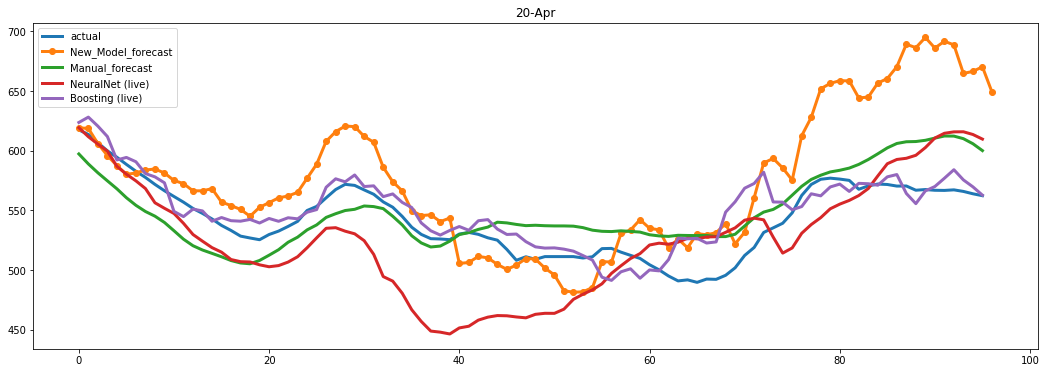

In [471]:
plt.plot(ff.iloc[:,-1],linewidth=3,label="actual")
plt.plot(y_pred, label="New_Model_forecast",linewidth=3, marker="o")
plt.plot(ff.final, label="Manual_forecast", linewidth=3)
plt.plot(ff.vvn, label="NeuralNet (live)", linewidth=3)
#plt.plot(ff.val, label="VAL", linewidth=2)
plt.plot(ff.vax, label="Boosting (live)", linewidth=3)
#plt.plot(ff.ves, label="VES", linewidth=2)
plt.legend()
plt.title("20-Apr")
plt.savefig("20.png")

In [ ]:
dtlist.extend(df4.datetime.tolist())
x_inf =df4.drop('datetime',1).copy()
                

# Other stuffs

In [224]:
temp = raw_wdf[(raw_wdf.datetime.dt.year == 2018)].reset_index(drop=True)
temp['date'] = temp.datetime.dt.date
temp['time'] = temp.datetime.dt.time
temp['year'] = temp.datetime.dt.year

In [225]:
new_wdf = pd.DataFrame()

In [226]:
temp[temp.datetime.dt.month == 4].pivot(index="time", values="temperature", columns='date')

date      2018-04-01  2018-04-02  2018-04-03  2018-04-04  2018-04-05  \
time                                                                   
00:00:00     24.7800     25.5100     27.2300     28.5400     28.7600   
00:15:00     24.8075     25.1625     27.1850     28.5825     28.8175   
00:30:00     24.8350     24.8150     27.1400     28.6250     28.8750   
00:45:00     24.8625     24.4675     27.0950     28.6675     28.9325   
01:00:00     24.8900     24.1200     27.0500     28.7100     28.9900   
01:15:00     24.8875     24.0100     26.8150     28.4475     28.7150   
01:30:00     24.8850     23.9000     26.5800     28.1850     28.4400   
01:45:00     24.8825     23.7900     26.3450     27.9225     28.1650   
02:00:00     24.8800     23.6800     26.1100     27.6600     27.8900   
02:15:00     24.6450     23.5725     25.6975     27.2800     27.3900   
02:30:00     24.4100     23.4650     25.2850     26.9000     26.8900   
02:45:00     24.1750     23.3575     24.8725     26.5200     26.3900   
03:00:00     23.9400     23.2500     24.4600     26.1400     25.8900   
03:15:00     24.1625     23.4075     24.5950     26.1225     26.2200   
03:30:00     24.3850     23.5650     24.7300     26.1050     26.5500   
03:45:00     24.6075     23.7225     24.8650     26.0875     26.8800   
04:00:00     24.8300     23.8800     25.0000     26.0700     27.2100   
04:15:00     24.5800     23.8775     24.9975     26.0675     27.1925   
04:30:00     24.3300     23.8750     24.9950     26.0650     27.1750   
04:45:00     24.0800     23.8725     24.9925     26.0625     27.1575   
05:00:00     23.8300     23.8700     24.9900     26.0600     27.1400   
05:15:00     23.5525     23.5975     24.4925     25.6225     26.6300   
05:30:00     23.2750     23.3250     23.9950     25.1850     26.1200   
05:45:00     22.9975     23.0525     23.4975     24.7475     25.6100   
06:00:00     22.7200     22.7800     23.0000     24.3100     25.1000   
06:15:00     22.7500     23.0525     23.5200     24.7800     25.6450   
06:30:00     22.7800     23.3250     24.0400     25.2500     26.1900   
06:45:00     22.8100     23.5975     24.5600     25.7200     26.7350   
07:00:00     22.8400     23.8700     25.0800     26.1900     27.2800   
07:15:00     23.1225     24.4225     25.3575     26.8650     27.4250   
07:30:00     23.4050     24.9750     25.6350     27.5400     27.5700   
07:45:00     23.6875     25.5275     25.9125     28.2150     27.7150   
08:00:00     23.9700     26.0800     26.1900     28.8900     27.8600   
08:15:00     24.3425     25.9550     26.4750     28.7825     27.9275   
08:30:00     24.7150     25.8300     26.7600     28.6750     27.9950   
08:45:00     25.0875     25.7050     27.0450     28.5675     28.0625   
09:00:00     25.4600     25.5800     27.3300     28.4600     28.1300   
09:15:00     26.0350     26.9650     28.5450     29.8075     29.1750   
09:30:00     26.6100     28.3500     29.7600     31.1550     30.2200   
09:45:00     27.1850     29.7350     30.9750     32.5025     31.2650   
10:00:00     27.7600     31.1200     32.1900     33.8500     32.3100   
10:15:00     28.0625     31.4025     32.6175     34.1525     32.7025   
10:30:00     28.3650     31.6850     33.0450     34.4550     33.0950   
10:45:00     28.6675     31.9675     33.4725     34.7575     33.4875   
11:00:00     28.9700     32.2500     33.9000     35.0600     33.8800   
11:15:00     29.4300     32.4675     34.0550     35.4250     34.1125   
11:30:00     29.8900     32.6850     34.2100     35.7900     34.3450   
11:45:00     30.3500     32.9025     34.3650     36.1550     34.5775   
12:00:00     30.8100     33.1200     34.5200     36.5200     34.8100   
12:15:00     31.3050     33.5900     35.3175     37.1075     35.1350   
12:30:00     31.8000     34.0600     36.1150     37.6950     35.4600   
12:45:00     32.2950     34.5300     36.9125     38.2825     35.7850   
13:00:00     32.7900     35.0000     37.7100     38.8700     36.1100   
13:15:00     33.0650     35.2825     37.

In [227]:
new_wdf['max_temp'] = temp[temp.datetime.dt.month == 4].pivot(index="time", values="temperature", columns='date').max()
new_wdf['min_temp'] = temp[temp.datetime.dt.month == 4].pivot(index="time", values="temperature", columns='date').min()

In [228]:
new_wdf["rol_max_temp"] = new_wdf.max_temp.rolling(3,min_periods=1).mean()
new_wdf["rol_min_temp"] = new_wdf.min_temp.rolling(3,min_periods=1).mean()

In [229]:
temp = raw_df[(raw_df.datetime.dt.year == 2018)].reset_index(drop=True)
temp['date'] = temp.datetime.dt.date
temp['time'] = temp.datetime.dt.time
temp['year'] = temp.datetime.dt.year
temp.drop_duplicates("datetime",inplace=True)

In [198]:
df = db.get_load_actual("2020-04-01","2020-04-21","token_intraday_1.json")
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df.datetime.dt.date
df['time'] = df.datetime.dt.time
df['year'] = df.datetime.dt.year
df.drop_duplicates("datetime",inplace=True)

reading from json file


In [199]:
df

datetime    load           created_at        date      time  \
0    2020-04-01 00:00:00  342.90  2020-04-02 08:05:04  2020-04-01  00:00:00   
1    2020-04-01 00:15:00  336.15  2020-04-02 08:05:04  2020-04-01  00:15:00   
2    2020-04-01 00:30:00  330.42  2020-04-02 08:05:04  2020-04-01  00:30:00   
3    2020-04-01 00:45:00  326.62  2020-04-02 08:05:04  2020-04-01  00:45:00   
4    2020-04-01 01:00:00  321.56  2020-04-02 08:05:04  2020-04-01  01:00:00   
...                  ...     ...                  ...         ...       ...   
2011 2020-04-21 22:45:00  599.14  2020-04-22 08:42:15  2020-04-21  22:45:00   
2012 2020-04-21 23:00:00  601.89  2020-04-22 08:42:15  2020-04-21  23:00:00   
2013 2020-04-21 23:15:00  602.69  2020-04-22 08:42:15  2020-04-21  23:15:00   
2014 2020-04-21 23:30:00  600.85  2020-04-22 08:42:15  2020-04-21  23:30:00   
2015 2020-04-21 23:45:00  598.02  2020-04-22 08:42:15  2020-04-21  23:45:00   

      year  
0     2020  
1     2020  
2     2020  
3     2020  
4     2020  
...    ...  
2011  2020  
2012  2020  
2013  2020  
2014  2020  
2015  2020  

[2016 rows x 6 columns]

In [230]:
new_wdf["load_avg"] = temp[temp.datetime.dt.month == 4].pivot(index="time", values="load", columns='date').mean()

In [231]:
new_wdf['rol_avg_load'] = new_wdf.load_avg.rolling(3,min_periods=1).mean()

In [233]:
new_wdf

max_temp  min_temp  rol_max_temp  rol_min_temp    load_avg  \
date                                                                     
2018-04-01     35.01     22.72     35.010000     22.720000         NaN   
2018-04-02     37.19     22.78     36.100000     22.750000  731.989792   
2018-04-03     39.98     23.00     37.393333     22.833333  766.418021   
2018-04-04     39.99     24.31     39.053333     23.363333  825.959062   
2018-04-05     38.89     25.10     39.620000     24.136667  859.908125   
2018-04-06     37.20     21.83     38.693333     23.746667  837.355833   
2018-04-07     35.02     20.72     37.036667     22.550000  795.013437   
2018-04-08     36.10     23.54     36.106667     22.030000  766.243229   
2018-04-09     30.18     24.08     33.766667     22.780000  753.495937   
2018-04-10     34.94     19.54     33.740000     22.386667  767.440417   
2018-04-11     32.60     24.38     32.573333     22.666667  773.230417   
2018-04-12     33.21     20.35     33.583333     21.423333  753.624375   
2018-04-13     37.18     20.10     34.330000     21.610000  758.115312   
2018-04-14     37.08     21.99     35.823333     20.813333  766.234583   
2018-04-15     39.10     24.01     37.786667     22.033333  776.488542   
2018-04-16     39.02     26.70     38.400000     24.233333  828.571875   
2018-04-17     39.83     26.79     39.316667     25.833333  846.311979   
2018-04-18     39.44     24.47     39.430000     25.986667  872.645417   
2018-04-19     40.68     25.67     39.983333     25.643333  900.627708   
2018-04-20     39.66     26.24     39.926667     25.460000  896.802187   
2018-04-21     34.24     23.51     38.193333     25.140000  867.848542   
2018-04-22     35.43     22.82     36.443333     24.190000  771.209583   
2018-04-23     37.63     21.61     35.766667     22.646667  800.961250   
2018-04-24     40.37     23.11     37.810000     22.513333  836.363542   
2018-04-25     42.06     25.66     40.020000     23.460000  900.765417   
2018-04-26     42.38     29.11     41.603333     25.960000  952.151354   
2018-04-27     41.06     28.16     41.833333     27.643333  987.779896   
2018-04-28     40.41     29.11     41.283333     28.793333  991.533333   
2018-04-29     41.30     28.37     40.923333     28.546667  953.581667   
2018-04-30     41.77     27.76     41.160000     28.413333         NaN   

            rol_avg_load  
date                      
2018-04-01           NaN  
2018-04-02    731.989792  
2018-04-03    749.203906  
2018-04-04    774.788958  
2018-04-05    817.428403  
2018-04-06    841.074340  
2018-04-07    830.759132  
2018-04-08    799.537500  
2018-04-09    771.584201  
2018-04-10    762.393194  
2018-04-11    764.722257  
2018-04-12    764.765069  
2018-04-13    761.656701  
2018-04-14    759.324757  
2018-04-15    766.946146  
2018-04-16    790.431667  
2018-04-17    817.124132  
2018-04-18    849.176424  
2018-04-19    873.195035  
2018-04-20    890.025104  
2018-04-21    888.426146  
2018-04-22    845.286771  
2018-04-23    813.339792  
2018-04-24    802.844792  
2018-04-25    846.030069  
2018-04-26    896.426771  
2018-04-27    946.898889  
2018-04-28    977.154861  
2018-04-29    977.631632  
2018-04-30    972.557500

In [236]:
new_wdf_18 = new_wdf.copy()

In [237]:
new_wdf_18

max_temp  min_temp  rol_max_temp  rol_min_temp    load_avg  \
date                                                                     
2018-04-01     35.01     22.72     35.010000     22.720000         NaN   
2018-04-02     37.19     22.78     36.100000     22.750000  731.989792   
2018-04-03     39.98     23.00     37.393333     22.833333  766.418021   
2018-04-04     39.99     24.31     39.053333     23.363333  825.959062   
2018-04-05     38.89     25.10     39.620000     24.136667  859.908125   
2018-04-06     37.20     21.83     38.693333     23.746667  837.355833   
2018-04-07     35.02     20.72     37.036667     22.550000  795.013437   
2018-04-08     36.10     23.54     36.106667     22.030000  766.243229   
2018-04-09     30.18     24.08     33.766667     22.780000  753.495937   
2018-04-10     34.94     19.54     33.740000     22.386667  767.440417   
2018-04-11     32.60     24.38     32.573333     22.666667  773.230417   
2018-04-12     33.21     20.35     33.583333     21.423333  753.624375   
2018-04-13     37.18     20.10     34.330000     21.610000  758.115312   
2018-04-14     37.08     21.99     35.823333     20.813333  766.234583   
2018-04-15     39.10     24.01     37.786667     22.033333  776.488542   
2018-04-16     39.02     26.70     38.400000     24.233333  828.571875   
2018-04-17     39.83     26.79     39.316667     25.833333  846.311979   
2018-04-18     39.44     24.47     39.430000     25.986667  872.645417   
2018-04-19     40.68     25.67     39.983333     25.643333  900.627708   
2018-04-20     39.66     26.24     39.926667     25.460000  896.802187   
2018-04-21     34.24     23.51     38.193333     25.140000  867.848542   
2018-04-22     35.43     22.82     36.443333     24.190000  771.209583   
2018-04-23     37.63     21.61     35.766667     22.646667  800.961250   
2018-04-24     40.37     23.11     37.810000     22.513333  836.363542   
2018-04-25     42.06     25.66     40.020000     23.460000  900.765417   
2018-04-26     42.38     29.11     41.603333     25.960000  952.151354   
2018-04-27     41.06     28.16     41.833333     27.643333  987.779896   
2018-04-28     40.41     29.11     41.283333     28.793333  991.533333   
2018-04-29     41.30     28.37     40.923333     28.546667  953.581667   
2018-04-30     41.77     27.76     41.160000     28.413333         NaN   

            rol_avg_load  rol_avg_load_norm  rol_max_temp_norm  
date                                                            
2018-04-01           NaN                NaN           0.263139  
2018-04-02    731.989792           0.000000           0.380850  
2018-04-03    749.203906           0.070078           0.520518  
2018-04-04    774.788958           0.174234           0.699784  
2018-04-05    817.428403           0.347818           0.760979  
2018-04-06    841.074340           0.444080           0.660907  
2018-04-07    830.759132           0.402087           0.482001  
2018-04-08    799.537500           0.274985           0.381569  
2018-04-09    771.584201           0.161188           0.128870  
2018-04-10    762.393194           0.123771           0.125990  
2018-04-11    764.722257           0.133253           0.000000  
2018-04-12    764.765069           0.133427           0.109071  
2018-04-13    761.656701           0.120773           0.189705  
2018-04-14    759.324757           0.111280           0.350972  
2018-04-15    766.946146           0.142306           0.562995  
2018-04-16    790.431667           0.237915           0.629230  
2018-04-17    817.124132           0.346579           0.728222  
2018-04-18    849.176424           0.477063           0.740461  
2018-04-19    873.195035           0.574842           0.800216  
2018-04-20    890.025104           0.643357           0.794096  
2018-04-21    888.426146           0.636847           0.606911  
2018-04-22    845.286771           0.461228           0.417927  
2018-04-23    813.339792           0.331173           0.344852  
2018-04-24    802.

In [234]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
zx = scaler.fit_transform(new_wdf)

In [168]:
new_wdf_19.head(2)

max_temp  min_temp  rol_max_temp  rol_min_temp   load_avg  \
date                                                                    
2019-04-01     31.85     17.17         31.85        17.170        NaN   
2019-04-02     33.15     18.64         32.50        17.905  665.85375   

            rol_avg_load  
date                      
2019-04-01           NaN  
2019-04-02     665.85375

In [235]:
new_wdf.loc[:,"rol_avg_load_norm"] = zx[:,-1]
new_wdf.loc[:,"rol_max_temp_norm"] = zx[:,2]

In [209]:
new_wdf_20

max_temp  min_temp  rol_max_temp  rol_min_temp    load_avg  \
date                                                                     
2020-04-01     33.44     21.34     33.440000     21.340000  414.524479   
2020-04-02     30.71     22.22     32.075000     21.780000  408.619687   
2020-04-03     32.09     19.88     32.080000     21.146667  413.277708   
2020-04-04     33.63     17.28     32.143333     19.793333  405.855833   
2020-04-05     33.56     18.28     33.093333     18.480000  414.929688   
2020-04-06     35.09     21.00     34.093333     18.853333  435.740000   
2020-04-07     34.95     21.74     34.533333     20.340000  448.139688   
2020-04-08     34.34     21.30     34.793333     21.346667  452.415625   
2020-04-09     34.52     20.73     34.603333     21.256667  450.148021   
2020-04-10     35.91     22.24     34.923333     21.423333  458.920104   
2020-04-11     37.21     23.77     35.880000     22.246667  484.205208   
2020-04-12     37.03     26.48     36.716667     24.163333  495.590729   
2020-04-13     38.44     26.42     37.560000     25.556667  526.920104   
2020-04-14     38.41     26.78     37.960000     26.560000  560.562708   
2020-04-15     38.32     26.28     38.390000     26.493333  583.637292   
2020-04-16     38.43     26.94     38.386667     26.666667  593.220000   
2020-04-17     36.40     25.96     37.716667     26.393333  592.733854   
2020-04-18     34.65     22.25     36.493333     25.050000  567.626354   
2020-04-19     35.55     22.99     35.533333     23.733333  534.363958   
2020-04-20     32.18     24.01     34.126667     23.083333  543.062708   
2020-04-21     34.38     21.37     34.036667     22.790000  529.035104   
2020-04-22     35.00     23.00     33.853333     22.793333         NaN   
2020-04-23     33.00     25.00     34.126667     23.123333         NaN   
2020-04-24     35.00     23.00     34.333333     23.666667         NaN   
2020-04-25     36.00     25.00     34.666667     24.333333         NaN   
2020-04-26     35.00     25.00     35.333333     24.333333         NaN   
2020-04-27     35.00     25.00     35.333333     25.000000         NaN   
2020-04-28     36.00     24.00     35.333333     24.666667         NaN   
2020-04-29     37.00     24.00     36.000000     24.333333         NaN   
2020-04-30     38.00     26.00     37.000000     24.666667         NaN   

            rol_avg_load  rol_avg_load_norm  rol_max_temp_norm  
date                                                            
2020-04-01    414.524479           0.029197           0.216152  
2020-04-02    411.572083           0.012851           0.000000  
2020-04-03    412.140625           0.015999           0.000792  
2020-04-04    409.251076           0.000000           0.010821  
2020-04-05    411.354410           0.011646           0.161256  
2020-04-06    418.841840           0.053101           0.319609  
2020-04-07    432.936458           0.131139           0.389285  
2020-04-08    445.431771           0.200322           0.430457  
2020-04-09    450.234444           0.226913           0.400369  
2020-04-10    453.827917           0.246809           0.451042  
2020-04-11    464.424444           0.305479           0.602534  
2020-04-12    479.572014           0.389347           0.735022  
2020-04-13    502.238681           0.514845           0.868567  
2020-04-14    527.691181           0.655769           0.931908  
2020-04-15    557.040035           0.818265           1.000000  
2020-04-16    579.140000           0.940626           0.999472  
2020-04-17    589.863715           1.000000           0.893376  
2020-04-18    584.526736           0.970451           0.699657  
2020-04-19    564.908056           0.861828           0.547638  
2020-04-20    548.351007           0.770156           0.324888  
2020-04-21    535.487257           0.698933           0.310636  
2020-04-22    536.048906           0.702043           0.281605  
2020-04-23    529.035104           0.663210           0.324888  
2020-04-24        

In [238]:
new_wdf_18.to_csv("April-2018.csv")

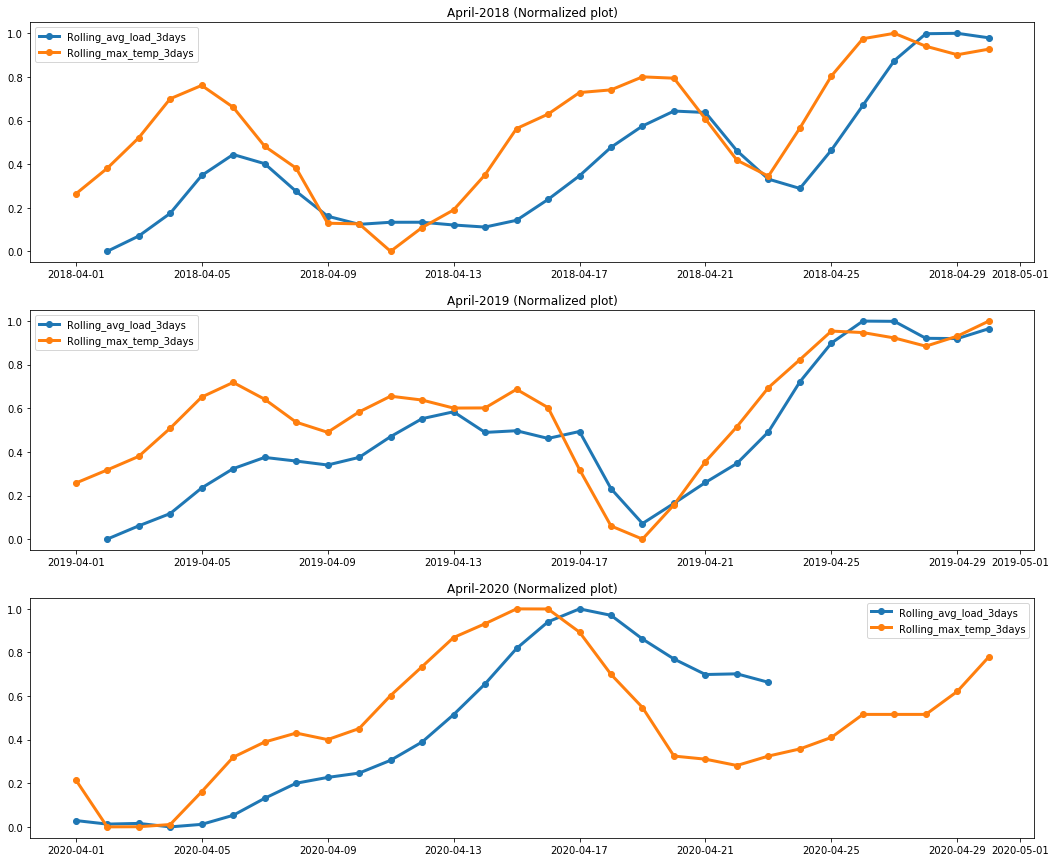

In [243]:
#plt.figure(figsize=(36,6))

fig, ax = plt.subplots(3,1, figsize=(18,15))

ax[0].plot(new_wdf_18.rol_avg_load_norm, label="Rolling_avg_load_3days", linewidth=3, marker='o')
ax[0].plot(new_wdf_18.rol_max_temp_norm, label="Rolling_max_temp_3days", linewidth=3, marker='o')
ax[0].set_title("April-2018 (Normalized plot)")
ax[0].legend()


ax[1].plot(new_wdf_19.rol_avg_load_norm, label="Rolling_avg_load_3days", linewidth=3, marker='o')
ax[1].plot(new_wdf_19.rol_max_temp_norm, label="Rolling_max_temp_3days", linewidth=3, marker='o')
ax[1].set_title("April-2019 (Normalized plot)")
ax[1].legend()
#plt.savefig("April-2020.png")
#plt.show()

ax[2].plot(new_wdf_20.rol_avg_load_norm, label="Rolling_avg_load_3days", linewidth=3, marker='o')
ax[2].plot(new_wdf_20.rol_max_temp_norm, label="Rolling_max_temp_3days", linewidth=3, marker='o')
ax[2].set_title("April-2020 (Normalized plot)")
ax[2].legend()

fig.savefig("Figure.jpg")


reading from json file
